In this notebook, we will explore the possibility of using dimensionality reduction techniques to solve a predictive modeling problem that is often used as an introduction to computer vision. Specifically, we will explore the utility of using dimensionality reduction techniques to correctly predict handwritten digits from the MNIST dataset. From https://en.wikipedia.org/wiki/MNIST_database:
> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.
>
> The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%

The following code block imports the libraries we will use.

In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pacmap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

The following code block reads both the feature data (`data`) and the labels (`target`).

In [2]:
data = pd.read_parquet('mnist_data.parquet')
target = pd.read_parquet('mnist_target.parquet')

The following code block shows that we have 70,000 examples in our data.

In [3]:
data.shape

(70000, 784)

As the previous cell shows, there are 784 columns in the feature data. Recall from the earlier description that the MNIST dataset includes images of size 28 pixels x 28 pixels. The total number of pixels is 784 (28 x 28), so each row represents a flattened vector of the pixels for a single image. The following code block defines a function to plot the image for a single row.

In [4]:
def plot_digit(index=0):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(
        data.iloc[index].values.reshape(28, 28),
        cmap='binary',
        cbar=False,
    )

    plt.show()

The following code block runs an interactive widget that allows you to view a sample of digits.

In [5]:
interact(plot_digit, index=range(100));

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

The following code block creates training and testing datasets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    target, 
    test_size=0.20, 
    random_state=42,
    stratify=target,
)

We will first look at how Principal Components Analysis fares for dimensionality reduction task. The following code block imports the PCA class from `scikit-learn`, fits the model on the training set with 2 components, and then prints the explained variance, which is rather low.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

sum(pca.explained_variance_ratio_)

0.16866806159358902

The following code block uses the fitted PCA to generate the reduced dimension embeddings for the training and testing datasets. 

In [8]:
pca_emb_train = pca.transform(X_train)
pca_emb_test = pca.transform(X_test)

Before we do any predictive modeling, let's visualize the PCA embeddings. This is done in the following code block, which first creates a `pandas` `DataFrame` with the embeddings and then generates a scatterplot that uses different colors for each label. The key thng to note is that the separation between classes is rather indistinct.

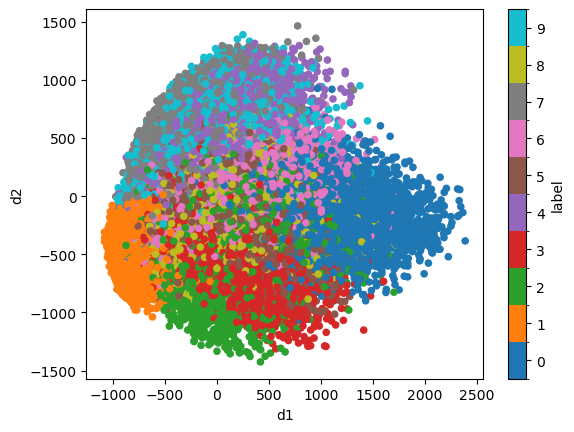

In [9]:
pca_emb_df = pd.DataFrame(
    pca_emb_train,
    columns=['d1', 'd2'],
)
pca_emb_df['label'] = y_train['class'].values

pca_emb_df.plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
);

The following code block runs an experiment where we use the labels to construct binary classification problems for each class. A random forest is then trained to predict the class based on the PCA embeddings. The baseline accuracy (accuracy we would get if we predicted none of the instances belonged to a class), training accuracy, and testing accuracy are printed for each of the classes in the data.

In [10]:
unique_classes = sorted(y_train['class'].unique().tolist())

for current_class in unique_classes:

    y_train_class = (y_train['class'] == current_class).astype(int)
    y_test_class = (y_test['class'] == current_class).astype(int)
    
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=6,
    )
    
    clf.fit(pca_emb_train, y_train_class)
    train_accuracy = clf.score(pca_emb_train, y_train_class)
    test_accuracy = clf.score(pca_emb_test, y_test_class)
    baseline_accuracy = 1.0 - y_train_class.sum()/len(y_train_class)
    
    print(f'Class: {current_class}')
    print(f' - {baseline_accuracy = :.4f}')
    print(f' - {train_accuracy = :.4f}')
    print(f' - {test_accuracy = :.4f}')
    print('-'*40)

Class: 0
 - baseline_accuracy = 0.9014
 - train_accuracy = 0.9532
 - test_accuracy = 0.9477
----------------------------------------
Class: 1
 - baseline_accuracy = 0.8875
 - train_accuracy = 0.9838
 - test_accuracy = 0.9804
----------------------------------------
Class: 2
 - baseline_accuracy = 0.9001
 - train_accuracy = 0.9088
 - test_accuracy = 0.9060
----------------------------------------
Class: 3
 - baseline_accuracy = 0.8980
 - train_accuracy = 0.9186
 - test_accuracy = 0.9138
----------------------------------------
Class: 4
 - baseline_accuracy = 0.9025
 - train_accuracy = 0.9052
 - test_accuracy = 0.9034
----------------------------------------
Class: 5
 - baseline_accuracy = 0.9098
 - train_accuracy = 0.9100
 - test_accuracy = 0.9098
----------------------------------------
Class: 6
 - baseline_accuracy = 0.9018
 - train_accuracy = 0.9028
 - test_accuracy = 0.9017
----------------------------------------
Class: 7
 - baseline_accuracy = 0.8958
 - train_accuracy = 0.9172
 - 

The previous results show that PCA is able to make some substantial improvements for a small number of classes (e.g., 0 and 1), but in general, it does not consistenly yield significant improvements over the baseline. 

We will now look at PACMAP (see https://github.com/YingfanWang/PaCMAP). The following code block fits a *default* version of the method and uses it to create training and testing sets of embedded values. **Note the need to provide a `basis` argument when transforming the test dataset.

In [11]:
reducer = pacmap.PaCMAP(random_state=42)

pacmap_emb_train = reducer.fit_transform(X_train)
pacmap_emb_test = reducer.transform(X_test, basis=X_train)

/home/nkfreeman/miniconda3/envs/crisp_env/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


The following code block visualizes the `PACMAP` embeddings. As you can see, the embeddings separate the classes much more distinctly than we observed with PCA.

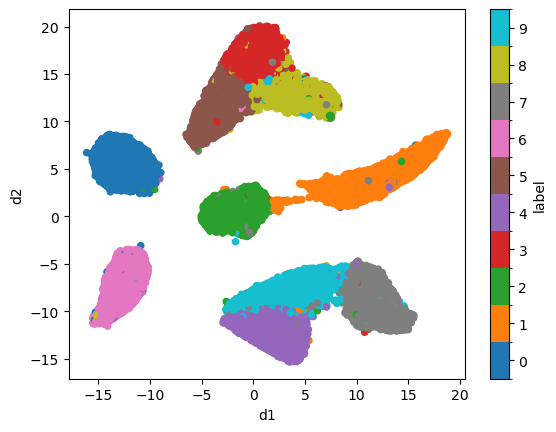

In [12]:
pacmap_emb_df = pd.DataFrame(
    pacmap_emb_train,
    columns=['d1', 'd2'],
)
pacmap_emb_df['label'] = y_train['class'].values

pacmap_emb_df.plot(
    kind='scatter',
    x='d1',
    y='d2',
    c='label',
    alpha=1.0,
    cmap='tab10',
);

The following code block runs an experiment where we use the labels to construct binary classification problems for each class. A random forest is then trained to predict the class based on the PACMAP embeddings. The baseline accuracy (accuracy we would get if we predicted none of the instances belonged to a class), training accuracy, and testing accuracy are printed for each of the classes in the data. In contrast to PCA, the lower-dimensional representations learned by the PACMAP method allow us to predict the correct class with around 99% accuracy, on average. Another important thing to note  is that we are doing all of this without a convolutional neural network.

In [13]:
unique_classes = sorted(y_train['class'].unique().tolist())

for current_class in unique_classes:

    y_train_class = (y_train['class'] == current_class).astype(int)
    y_test_class = (y_test['class'] == current_class).astype(int)
    
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=6,
    )
    
    clf.fit(pacmap_emb_train, y_train_class)
    train_accuracy = clf.score(pacmap_emb_train, y_train_class)
    test_accuracy = clf.score(pacmap_emb_test, y_test_class)
    baseline_accuracy = 1.0 - y_train_class.sum()/len(y_train_class)
    
    print(f'Class: {current_class}')
    print(f' - {baseline_accuracy = :.4f}')
    print(f' - {train_accuracy = :.4f}')
    print(f' - {test_accuracy = :.4f}')
    print('-'*40)

Class: 0
 - baseline_accuracy = 0.9014
 - train_accuracy = 0.9986
 - test_accuracy = 0.9968
----------------------------------------
Class: 1
 - baseline_accuracy = 0.8875
 - train_accuracy = 0.9972
 - test_accuracy = 0.9954
----------------------------------------
Class: 2
 - baseline_accuracy = 0.9001
 - train_accuracy = 0.9960
 - test_accuracy = 0.9891
----------------------------------------
Class: 3
 - baseline_accuracy = 0.8980
 - train_accuracy = 0.9935
 - test_accuracy = 0.9866
----------------------------------------
Class: 4
 - baseline_accuracy = 0.9025
 - train_accuracy = 0.9963
 - test_accuracy = 0.9928
----------------------------------------
Class: 5
 - baseline_accuracy = 0.9098
 - train_accuracy = 0.9962
 - test_accuracy = 0.9909
----------------------------------------
Class: 6
 - baseline_accuracy = 0.9018
 - train_accuracy = 0.9979
 - test_accuracy = 0.9946
----------------------------------------
Class: 7
 - baseline_accuracy = 0.8958
 - train_accuracy = 0.9956
 - 